In [12]:
import pyomo.environ as pyo
import os
import pandas as pd

In [17]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

class BenchmarkOpti:

    def __init__(self, params_dict):
        #
        # Define the parameters given in dictionary
        #
        self.battery_capacities = params_dict['battery_capacities']
        self.battery_min_capacities = params_dict['battery_min_capacities']
        self.battery_charging_power = params_dict['battery_charging_power']
        self.battery_discharging_power = params_dict['battery_discharging_power']
        self.grid_max_power = params_dict['grid_max_power']
        self.inital_soe = params_dict['inital_soe']
        self.feed_in_tariff = params_dict['feed_in_tariff']
        self.time = params_dict['time']
        self.eco_factor = params_dict['eco_factor']

        #
        # Prices in length of time
        #
        self.cost_buy = params_dict['cost_buy']
        self.profit_sell = params_dict['profit_sell']

        #
        # Netload in length of time
        #
        self.netload = params_dict['netload']

        #
        # Emission costs in length of time
        #
        self.emissions = params_dict['emissions']

        #
        # Model definition
        #
        self.model = pyo.AbstractModel()
        self.define_model(self.model)

    #
    # Define the model
    #
    def define_model(self, model):
        model.time = pyo.RangeSet(1, self.time)

        #
        # Decision Variables
        #
        model.energy_sell = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.energy_buy = pyo.Var(model.time, domain=pyo.NonNegativeReals)
        model.sell_buy = pyo.Var(model.time, domain=pyo.Binary)
        model.sell_buy_penalty = pyo.Var(model.time, domain=pyo.NonNegativeReals)

        #
        # Battery action
        #
        model.battery_action = pyo.Var(model.time, domain=pyo.Reals)
        model.soe = pyo.Var(model.time, domain=pyo.NonNegativeReals)

        #
        # Time dependent costs
        #
        model.cost_buy = pyo.Param(model.time, initialize=self.cost_buy, domain=pyo.NonNegativeReals)
        model.profit_sell = pyo.Param(model.time, initialize=self.profit_sell, domain=pyo.NonNegativeReals)

        #
        # Time dependent netload
        #
        model.netload = pyo.Param(model.time, initialize=self.netload, domain=pyo.Reals)

        #
        # Time dependent emissions
        #
        model.emissions = pyo.Param(model.time, initialize=self.emissions, domain=pyo.Reals)

        #
        # Activate the constraints
        #
        model.constraint_soe = pyo.Constraint(model.time, rule=self.constraint_rule_soe)
        model.constraint_soe_min = pyo.Constraint(model.time, rule=self.constraint_rule_soe_min)
        model.constraint_soe_initial = pyo.Constraint(rule=self.constraint_rule_soe_initial)

        model.constraint_energy_sell = pyo.Constraint(model.time, rule=self.constraint_energy_sell)
        model.constraint_energy_buy = pyo.Constraint(model.time, rule=self.constraint_energy_buy)

        model.constraint_max_battery_action = pyo.Constraint(model.time, rule=self.constraint_max_battery_action)
        model.constraint_min_battery_action = pyo.Constraint(model.time, rule=self.constraint_min_battery_action)
        model.constraint_soe_proagation = pyo.Constraint(model.time, rule=self.constraint_soe_propagation)

        model.constraint_big_M = pyo.Constraint(model.time, rule=self.constraint_big_M)

        #
        # Define objective function
        #
        model.obj = pyo.Objective(rule=self.objective_rule, sense=pyo.maximize)

    #
    # Objective Rule
    #
    def objective_rule(self, model):
        profit = sum(model.energy_sell[t] * model.profit_sell[t] for t in model.time)
        cost = sum(model.energy_buy[t] * model.cost_buy[t] for t in model.time)
        emission_cost = sum(model.energy_buy[t] * model.emissions[t] for t in model.time)
        penalty = sum(model.sell_buy_penalty[t] for t in model.time)
        
        
        return (1 - self.eco_factor) * (profit - cost) - self.eco_factor * emission_cost - penalty
    
    #
    # Constraints
    #
    def constraint_rule_soe(self, model, t):
        return model.soe[t] <= self.battery_capacities
    
    def constraint_rule_soe_min(self, model,t):
        if t == 1:
            return pyo.Constraint.Skip
        return model.soe[t] >= self.battery_min_capacities

    def constraint_rule_soe_initial(self, model):
        return model.soe[1] == self.inital_soe
    

    def constraint_big_M(self, model, t):
        return model.sell_buy_penalty[t] == model.sell_buy[t] * (1-model.sell_buy[t]) * 10000000000000000000000000

    
    def constraint_energy_sell(self, model, t):
        return model.energy_sell[t] == (model.netload[t] - model.battery_action[t]) * model.sell_buy[t] * -1

    def constraint_energy_buy(self, model, t):
        return model.energy_buy[t] == (model.netload[t] - model.battery_action[t]) * (1 - model.sell_buy[t])
    
    def constraint_max_battery_action(self, model, t):
        return model.battery_action[t] <= self.battery_charging_power
    
    def constraint_min_battery_action(self, model, t):
        return model.battery_action[t] >= -self.battery_discharging_power

    def constraint_soe_propagation(self, model, t):
        if t == 1:
            return pyo.Constraint.Skip
        return model.soe[t] == model.soe[t-1] - model.battery_action[t-1]

    #
    # Solve the model
    #
    def solve_model(self):
        instance = self.model.create_instance()
        solver = pyo.SolverFactory('ipopt')
        solver.solve(instance, tee=True)
        self.instance = instance

    #
    # Visualize the results
    #
    def visualize_results(self):
        time = list(self.instance.time)
        energy_sell = [self.instance.energy_sell[t].value for t in time]
        energy_buy = [self.instance.energy_buy[t].value for t in time]
        soe = [self.instance.soe[t].value for t in time]

        # Calculate the profit
        profit = sum(energy_sell[t-1] * self.profit_sell[t] for t in time)
        cost = sum(energy_buy[t-1] * self.cost_buy[t] for t in time)
        total_profit = profit - cost

        # Print the profit
        print(f'Total Profit: {total_profit}')

        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(time, energy_sell, label='Energy Sell')
        plt.plot(time, energy_buy, label='Energy Buy')
        plt.xlabel('Time')
        plt.ylabel('Energy')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(time, soe, label='State of Energy (SoE)')
        plt.xlabel('Time')
        plt.ylabel('SoE')
        plt.legend()


        plt.tight_layout()
        plt.show()

        #plot the action and the soe

        plt.figure(figsize=(12, 8))
        plt.plot(time, [self.instance.battery_action[t].value for t in time], label='Battery Action')   
        plt.plot(time, soe, label='State of Energy (SoE)')
        plt.xlabel('Time')
        plt.ylabel('Battery Action')
        plt.legend()

        #enable grid in the plot
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        

        # plot the netload

        plt.figure(figsize=(12, 8))
        plt.plot(time, [self.netload[t] for t in time], label='Netload')
        plt.xlabel('Time')
        plt.ylabel('Netload')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # plot the netload, the action and the battery in a diagram 

        plt.figure(figsize=(12, 8))
        plt.plot(time, [self.netload[t] for t in time], label='Netload')
        plt.plot(time, [self.instance.battery_action[t].value for t in time], label='Battery Action')
        plt.plot(time, soe, label='State of Energy (SoE)')
        plt.xlabel('Time')
        plt.ylabel('Netload, Battery Action and SoE')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        # vizualize sell buy
        plt.figure(figsize=(12, 8))
        plt.plot(time, [self.instance.sell_buy[t].value for t in time], label='Sell Buy')
        plt.xlabel('Time')
        plt.ylabel('Sell Buy')
        plt.legend()
        plt.tight_layout()
        plt.show()
        

        # plot penalty

        plt.figure(figsize=(12, 8))
        plt.plot(time, [self.instance.sell_buy_penalty[t].value for t in time], label='Penalty')
        plt.xlabel('Time')
        plt.ylabel('Penalty')
        plt.legend()
        plt.tight_layout()
        plt.show()


    def get_profit(self):
        time = list(self.instance.time)
        energy_sell = [self.instance.energy_sell[t].value for t in time]
        energy_buy = [self.instance.energy_buy[t].value for t in time]

        # Calculate the profit
        profit = sum(energy_sell[t-1] * self.profit_sell[t] for t in time)
        cost = sum(energy_buy[t-1] * self.cost_buy[t] for t in time)
        total_profit = profit - cost

        return total_profit
    
    def get_action(self):
        time = list(self.instance.time)
        return [self.instance.battery_action[t].value for t in time]
    

        




In [14]:
# load the data   

import pandas as pd

energy_data = pd.read_csv("../../data/3final_data/Final_Energy_dataset.csv").fillna(0).set_index('Date')
    #emission_data = pd.read_csv(path_emission_data, index_col=0, parse_dates=True).fillna(0)
    #energy_data['emissions'] = emission_data['emissions'] 
    
dataset = {"train": {}, "eval": {}, "test": {}}
environments = {"train": {}, "eval": {}, "test": {}}
   
for idx in range(30):
    user_data = energy_data[[f'load_{idx+1}', f'pv_{idx+1}', 'price', 'emissions']]
        
    dataset["train"][f"building_{idx+1}"] = user_data[0:17520].set_index(pd.RangeIndex(0,17520))
    dataset["eval"][f"building_{idx+1}"] = user_data[17520:35088].set_index(pd.RangeIndex(0,17568))
    dataset["test"][f"building_{idx+1}"] = user_data[35088:52608].set_index(pd.RangeIndex(0,17520))

Ipopt 3.14.14: 
==> Warning: Treating 0 binary and 17520 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   192718
Number of nonzeros in inequality constraint Jacobian.:    70079
Number of nonzeros in Lagrangian Hessian.............:    35040

Total number of variables............................:   105120
                     variables with only lower bounds:    70080
                variables with lower and upper bounds:    17520
                     variables with only upper bounds:        0
T

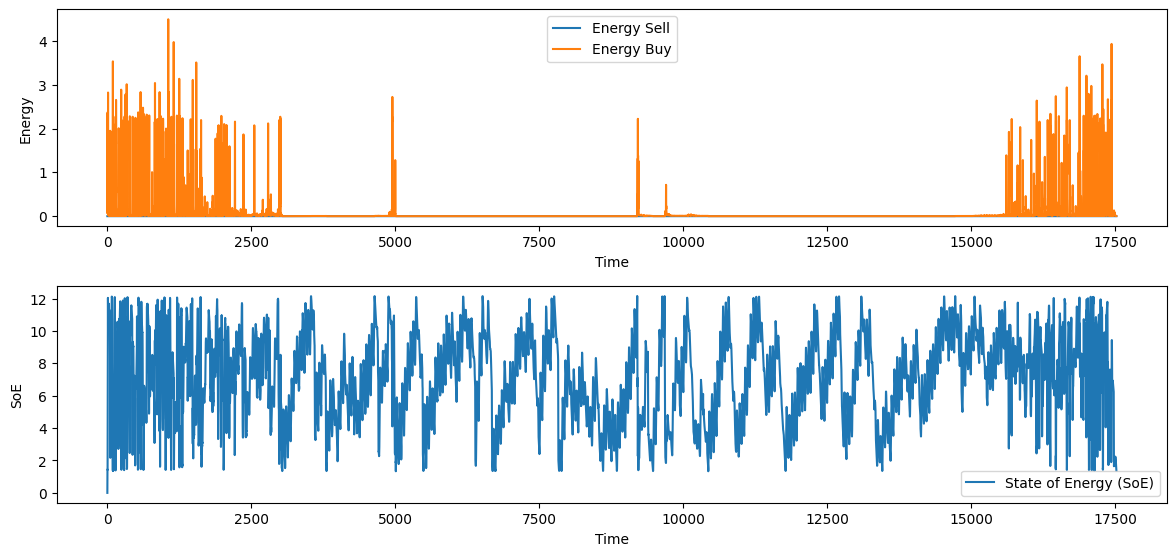

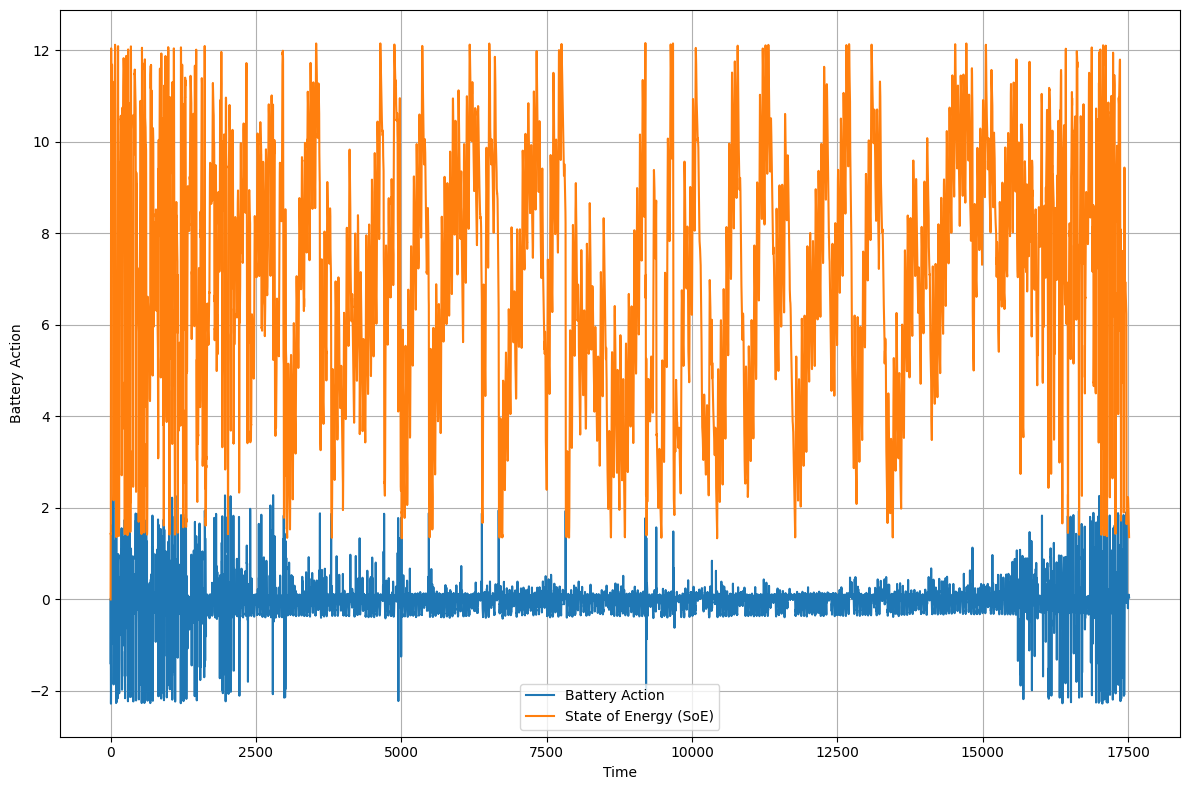

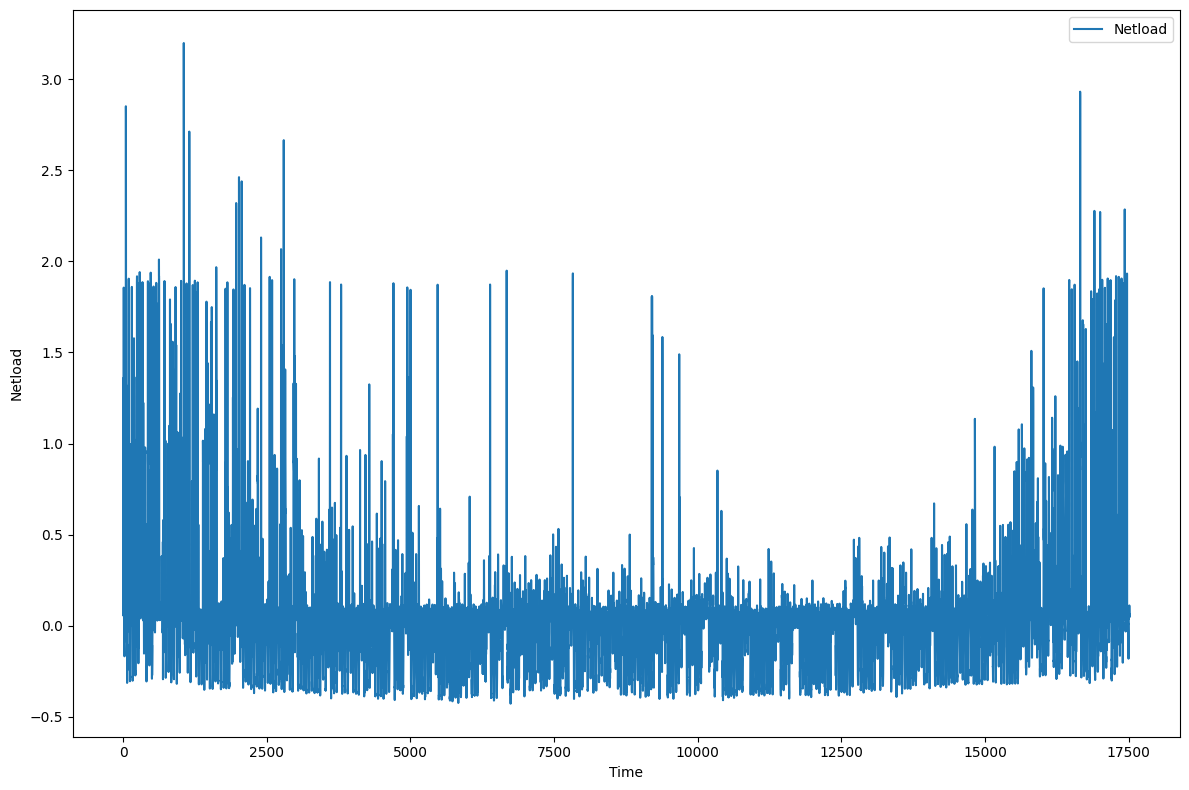

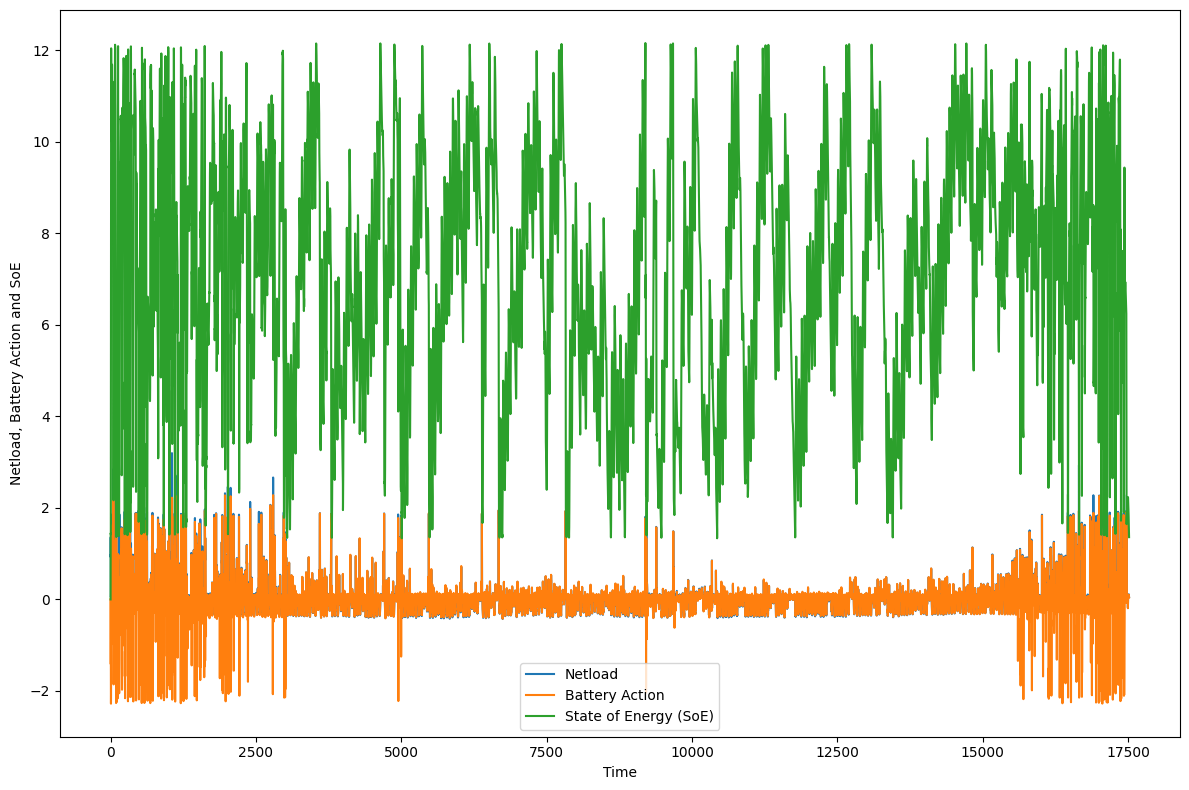

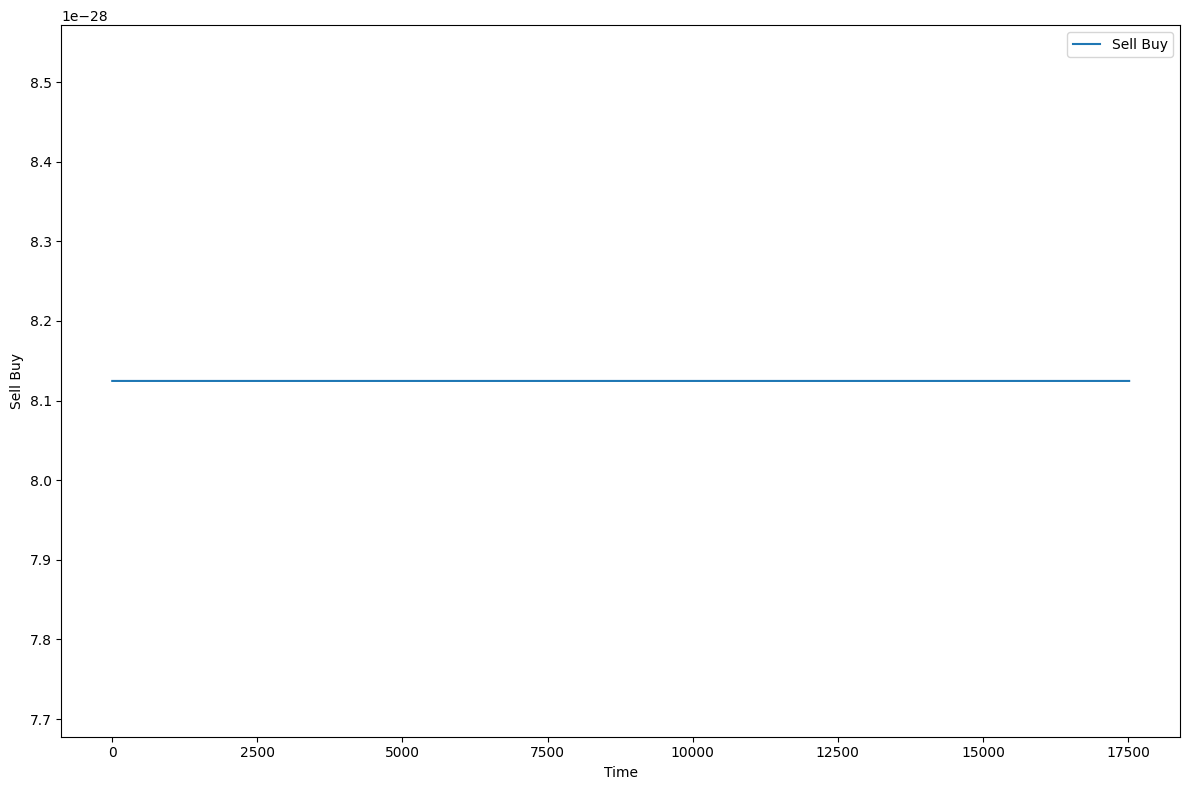

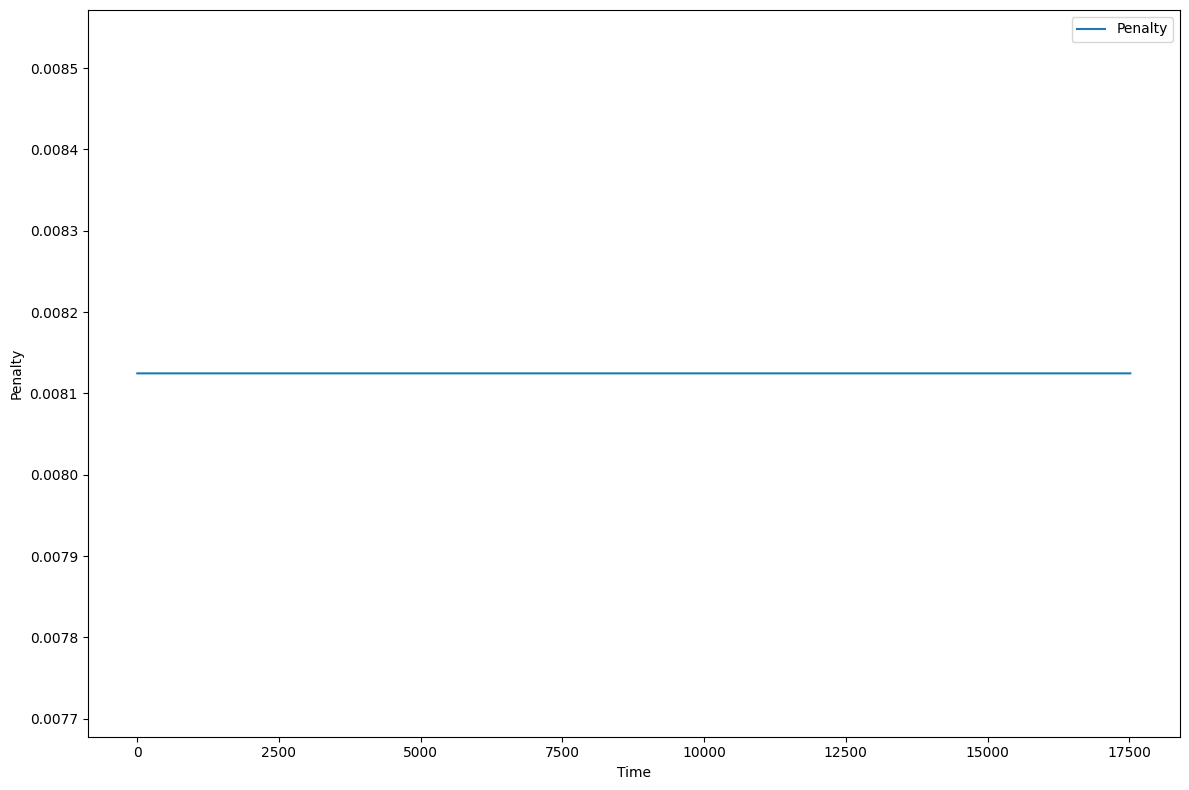

In [15]:
# extract the data for building 1
#

load = dataset["test"]["building_3"]['load_3']
pv = dataset["test"]["building_3"]['pv_3']

netload = load - pv

emmisions = dataset["test"]["building_3"]['emissions']
cost_buy = dataset["test"]["building_3"]['price']


time_stamps = 17520

# Example usage
params_dict = {
    'battery_capacities': 13.5 * 0.9,
    'battery_min_capacities' : 0.1 * 13.5,
    'battery_charging_power': 2.3,
    'battery_discharging_power': 2.3,
    'grid_max_power': 25,
    'inital_soe': 0,
    'feed_in_tariff': 0.076,
    'time': time_stamps,
    'eco_factor': 0.0,
    'cost_buy': {i: cost_buy[i-1] for i in range(1, time_stamps+1)},
    'profit_sell': {i: 0.076 for i in range(1,  time_stamps+1)},
    'netload': {i: netload[i-1] for i in range(1,  time_stamps+1)},
    'emissions': {i: emmisions[i-1] for i in range(1,  time_stamps+1)}
}

benchmark = BenchmarkOpti(params_dict)
benchmark.solve_model()
benchmark.visualize_results()

In [21]:
# do the problem for building 1 to 30
# and get the profit for each building
# and the action for each building

profits = []
actions = []

for idx in range(30):
    print(f"Building {idx+1}")

    # extract the data for the building
    
    load = dataset["test"][f"building_{idx+1}"][f'load_{idx+1}']
    pv = dataset["test"][f"building_{idx+1}"][f'pv_{idx+1}']

    netload = load - pv

    emmisions = dataset["test"][f"building_{idx+1}"]['emissions']
    cost_buy = dataset["test"][f"building_{idx+1}"]['price']


    time_stamps = 10

    # Example usage
    params_dict = {
        'battery_capacities': 13.5 * 0.9,
        'battery_min_capacities' : 0.0 + 0.1 * 13.5,
        'battery_charging_power': 2.3,
        'battery_discharging_power': 2.3,
        'grid_max_power': 25,
        'inital_soe': 0,
        'feed_in_tariff': 0.076,
        'time': time_stamps,
        'eco_factor': 0.0,
        'cost_buy': {i: cost_buy[i-1] for i in range(1, time_stamps+1)},
        'profit_sell': {i: 0.076 for i in range(1,  time_stamps+1)},
        'netload': {i: netload[i-1] for i in range(1,  time_stamps+1)},
        'emissions': {i: emmisions[i-1] for i in range(1,  time_stamps+1)}
    }

   

    benchmark = BenchmarkOpti(params_dict)
    benchmark.solve_model()
    #benchmark.visualize_results()
    profits.append(benchmark.get_profit())
    actions.append(benchmark.get_action())

    # save the profits and the actions as csv files

    profits_df = pd.DataFrame(profits, columns=['profits']).T
    actions_df = pd.DataFrame(actions).T
    # increment the columns of the actions_df and the profits_df by 1
    actions_df.columns = actions_df.columns + 1
    profits_df.columns = profits_df.columns + 1




    # save it in a specific folder optimisation problem make this folder in results folder

    os.makedirs("../../results/optimisation_problem", exist_ok=True)


    profits_df.to_csv("../../results/optimisation_problem/profits.csv")
    actions_df.to_csv("../../results/optimisation_problem/actions.csv")





Building 1
Ipopt 3.14.14: 
==> Warning: Treating 0 binary and 10 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:       39
Number of nonzeros in Lagrangian Hessian.............:       20

Total number of variables............................:       60
                     variables with only lower bounds:       40
                variables with lower and upper bounds:       10
                     variables with only upper bounds:   